# Creació de models

In [1]:
pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scikeras.wrappers import  KerasRegressor

2024-06-17 10:01:40.752679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 10:01:40.752777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 10:01:40.875954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = "/kaggle/input/co2-rnn/"

X = np.load(data_dir + 'X.npy', allow_pickle=True)
y = np.load(data_dir + 'y.npy', allow_pickle=True)

metadata = pd.read_csv(data_dir + 'metadata.csv')
metadata["date_time"] = pd.to_datetime(metadata["date_time"])

In [4]:
# Split train/test
test_size = 0.15
test_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:test_index], X[test_index:]
y_train, y_test = y[:test_index], y[test_index:]
metadata_train, metadata_test = metadata.iloc[:test_index], metadata.iloc[test_index:].reset_index(drop=True)
    

In [5]:
print("Dimensió X_dynamic_train: ", X_train.shape)
print("Dimensió y_train: ", y_train.shape)
print("Dimensió metadata_train: ", metadata_train.shape)

print("\nDimensió X_dynamic_test: ", X_test.shape)
print("Dimensió y_test: ", y_test.shape)
print("Dimensió metadata_test: ", metadata_test.shape)

Dimensió X_dynamic_train:  (65234, 7, 13)
Dimensió y_train:  (65234,)
Dimensió metadata_train:  (65234, 4)

Dimensió X_dynamic_test:  (11512, 7, 13)
Dimensió y_test:  (11512,)
Dimensió metadata_test:  (11512, 4)


# El model més simple
Per tenir un punt de partida establim el model més simple corresponen a predir totes les dades

In [6]:
y_train_mean = np.mean(y_train)

y_train_pred = np.full_like(y_train, y_train_mean)
y_test_pred = np.full_like(y_test, y_train_mean)

# Calcular metriques
metrics_df = pd.DataFrame(data={
    'MAE'     : [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
    'MSE'     : [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],    
    'R²'      : [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)],
    'MAPE (%)': [mean_absolute_percentage_error(y_train, y_train_pred), mean_absolute_percentage_error(y_test, y_test_pred)]
}, index=["entrenament", "test"])

# Mostrar-les
display(metrics_df)

,MAE,MSE,R²,MAPE (%)
entrenament,0.036854,0.004596,0.000000,0.372516
test,0.029510,0.001656,-0.109818,0.343591


# Model lineal
Axafem les dades dinamiques i concatenar les dades estatiques d'una instancia per tenirla en fromat d'un unic array per instancia, entrenem un model lineal amb les dades d'entrenament i observem els resultats sobre validació i test.

In [7]:
# aplanar dades i junta les dades statiques i dinamiques en un sol vector
def flater_concater (X):
    X_flat = []
    for array in X:
        X_flat.append(np.ravel(array)[:-7])
     
    return np.array(X_flat)

In [8]:
X_train_flat = flater_concater(X_train)
X_test_flat = flater_concater(X_test)

In [9]:
# Model regresió lineal
model = LinearRegression()

model.fit(X_train_flat, y_train)

y_train_pred = model.predict(X_train_flat)
y_test_pred = model.predict(X_test_flat)

# Calcular metriques
metrics_df = pd.DataFrame(data={
    'MAE'     : [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
    'MSE'     : [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],    
    'R²'      : [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)],
    'MAPE (%)': [mean_absolute_percentage_error(y_train, y_train_pred), mean_absolute_percentage_error(y_test, y_test_pred)]
}, index=["entrenament", "test"])

# Mostrar-les
display(metrics_df)

,MAE,MSE,R²,MAPE (%)
entrenament,0.005366,0.000195,0.957530,0.044199
test,0.004409,0.000131,0.912267,0.040983


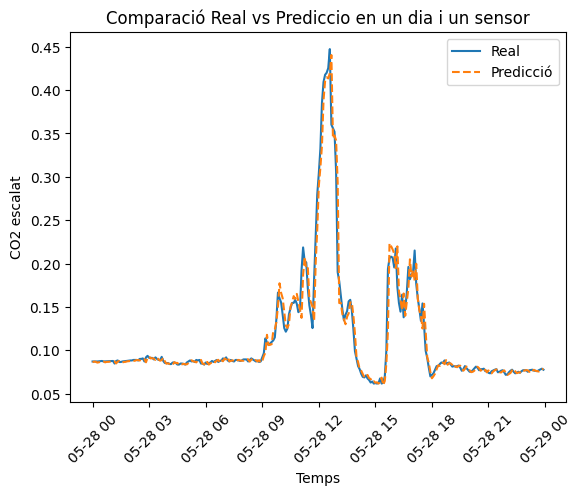

In [10]:
subset = metadata_test[(metadata_test["date_time"].dt.day == 28) & (metadata_test["location"] == "SantMiquel") & (metadata_test["sensor_id"] == "CO2_01")]
i = subset.index


plt.plot(subset['date_time'],y_test[i], label='Real')
plt.plot(subset['date_time'],y_test_pred[i], label='Predicció', linestyle='dashed')
plt.title('Comparació Real vs Prediccio en un dia i un sensor')
plt.xlabel('Temps')
plt.ylabel('CO2 escalat')
plt.xticks(rotation=45)
plt.legend()

# LSTM Model

A continuació es mostra un exemple de model, amb l'intenció de poder mostra la seva estructura

In [11]:
inpt = Input(shape=(7, 13))
   
static_input = Lambda(lambda x: x[:, -1:,:-7])(inpt)

static_flatten = tf.keras.layers.Flatten()(static_input)

dynamic_input = Lambda(lambda x: x[:, :-1])(inpt)

dynamic_output = LSTM(12, 
                   return_sequences=False, 
                   dropout=0.1,
                   recurrent_dropout=0.1)(dynamic_input)

x = concatenate([dynamic_output, static_flatten])
x = Dense(6, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[inpt], outputs=output)

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 6, 13)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 6)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12)        │      1,248 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6)         │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 18)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │        114 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          7 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,369 (5.35 KB)

 Trainable params: 1,369 (5.35 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
param_grid = {

    'model__lstm_units': [12, 24],

    'model__dense_units': [6, 12],

    'model__dropout_rate': [0.0, 0.1, 0.2],

    'epochs': [100]

}

In [13]:
def definir_model(lstm_units, dense_units, dropout_rate):
    inpt = Input(shape=(7, 13))
   
    static_input = Lambda(lambda x: x[:, -1:,:-7])(inpt)
    
    static_flatten = tf.keras.layers.Flatten()(static_input)
    
    dynamic_input = Lambda(lambda x: x[:, :-1])(inpt)
    
    dynamic_output = LSTM(lstm_units, 
                       return_sequences=False, 
                       dropout=dropout_rate)(dynamic_input)

    x = concatenate([dynamic_output, static_flatten])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[inpt], outputs=output)
    
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mae')
    return model

In [14]:
model_path = '/kaggle/working/model.weights.h5'

# Definir els callbacks
checkpoint = ModelCheckpoint(filepath=model_path, 
                             monitor='loss',
                             save_weights_only=True,
                             save_best_only=True)

early_stopping = EarlyStopping(monitor='loss', 
                               patience=10, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)

In [15]:
regressor = KerasRegressor(definir_model,verbose=0,callbacks=[checkpoint,reduce_lr,early_stopping])

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(estimator=regressor, verbose=4, param_grid=param_grid, cv=tscv,scoring='neg_mean_absolute_error')

print("Starting GridSearchCV.fit...")
grid.fit(X_train, y_train)

Starting GridSearchCV.fit...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END epochs=100, model__dense_units=6, model__dropout_rate=0.0, model__lstm_units=12;, score=-0.006 total time= 1.9min
[CV 2/5] END epochs=100, model__dense_units=6, model__dropout_rate=0.0, model__lstm_units=12;, score=-0.006 total time= 3.8min
[CV 3/5] END epochs=100, model__dense_units=6, model__dropout_rate=0.0, model__lstm_units=12;, score=-0.005 total time= 5.6min
[CV 4/5] END epochs=100, model__dense_units=6, model__dropout_rate=0.0, model__lstm_units=12;, score=-0.005 total time= 5.9min
[CV 5/5] END epochs=100, model__dense_units=6, model__dropout_rate=0.0, model__lstm_units=12;, score=-0.027 total time= 7.0min
[CV 1/5] END epochs=100, model__dense_units=6, model__dropout_rate=0.0, model__lstm_units=24;, score=-0.005 total time= 1.9min
[CV 2/5] END epochs=100, model__dense_units=6, model__dropout_rate=0.0, model__lstm_units=24;, score=-0.006 total time= 3.8min
[CV 3/5] END epochs=1

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KerasRegressor(callbacks=[<keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ce2668627d0>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x7ce2668639d0>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ce266863ac0>], model=<function definir_model at 0x7ce2663fc040>, verbose=0),
             param_grid={'epochs': [100], 'model__dense_units': [6, 12],
                         'model__dropout_rate': [0.0, 0.1, 0.2],
                         'model__lstm_units': [12, 24]},
             scoring='neg_mean_absolute_error', verbose=4)

In [16]:
# Resultats
print("Millors parametres:")
print(grid.best_params_)

print("\nMillor score:")
print(grid.best_score_)

print("\nMillor estimador:")
print(grid.best_estimator_)

print("\nResultats detallats GridSearch:")
resultats = pd.DataFrame(grid.cv_results_)
display(resultats.sort_values(by='mean_test_score').head())
resultats.to_csv('resultatsGridSearch.csv', index=False)

print("\nDuració:")
print(f"{grid.refit_time_:.3f} segons")

Millors parametres:
{'epochs': 100, 'model__dense_units': 12, 'model__dropout_rate': 0.0, 'model__lstm_units': 12}

Millor score:
-0.005094920245565763

Millor estimador:
KerasRegressor(
	model=<function definir_model at 0x7ce2663fc040>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=[<keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ce269f13cd0>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x7ce269f12140>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ce1cab914e0>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	model__dense_units=12
	model__dropout_rate=0.0
	model__lstm_units=12
)

Resultats detallats GridSearch:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_model__dense_units,param_model__dropout_rate,param_model__lstm_units,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,516.077914,213.454605,1.664939,0.042430,100,6,0.2,24,"{'epochs': 100, 'model__dense_units': 6, 'mode...",-0.028140,-0.019971,-0.019455,-0.027834,-0.020334,-0.023147,0.003963,12
4,422.705067,214.650956,1.877280,0.367582,100,6,0.2,12,"{'epochs': 100, 'model__dense_units': 6, 'mode...",-0.028151,-0.021795,-0.016982,-0.018451,-0.020997,-0.021275,0.003848,11
10,453.443786,212.485936,1.646285,0.031304,100,12,0.2,12,"{'epochs': 100, 'model__dense_units': 12, 'mod...",-0.020805,-0.021162,-0.019493,-0.018682,-0.019830,-0.019994,0.000897,10
11,534.007388,198.732426,1.706265,0.037424,100,12,0.2,24,"{'epochs': 100, 'model__dense_units': 12, 'mod...",-0.020977,-0.020312,-0.019946,-0.018259,-0.019651,-0.019829,0.000901,9
2,489.513333,248.419355,1.635927,0.044121,100,6,0.1,12,"{'epochs': 100, 'model__dense_units': 6, 'mode...",-0.010525,-0.011595,-0.011223,-0.010344,-0.010919,-0.010921,0.000455,8



Duració:
544.230 segons


In [17]:
model = grid

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular metriques
metrics_df = pd.DataFrame(data={
    'MAE'     : [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
    'MSE'     : [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],    
    'R²'      : [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)],
    'MAPE (%)': [mean_absolute_percentage_error(y_train, y_train_pred), mean_absolute_percentage_error(y_test, y_test_pred)]
}, index=["entrenament", "test"])

# Mostrar-les
display(metrics_df)

,MAE,MSE,R²,MAPE (%)
entrenament,0.004830,0.000175,0.962003,0.038659
test,0.004167,0.000128,0.914092,0.037447


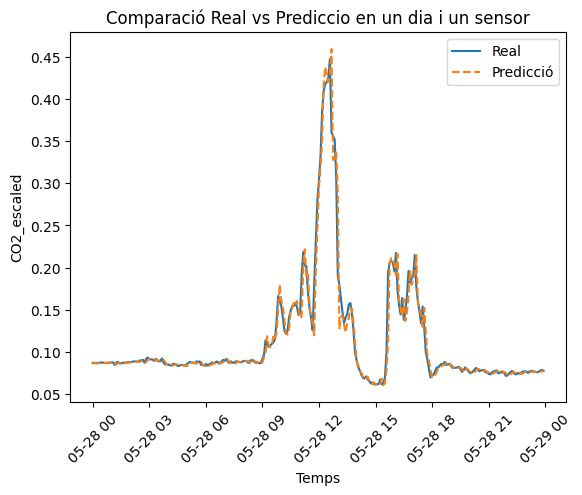

In [18]:
subset = metadata_test[(metadata_test["date_time"].dt.day == 28) & (metadata_test["location"] == "SantMiquel") & (metadata_test["sensor_id"] == "CO2_01")]
i = subset.index


plt.plot(subset['date_time'],y_test[i], label='Real')
plt.plot(subset['date_time'],y_test_pred[i], label='Predicció', linestyle='dashed')
plt.title('Comparació Real vs Prediccio en un dia i un sensor')
plt.xlabel('Temps')
plt.ylabel('CO2_escaled')
plt.xticks(rotation=45)
plt.legend()